# Application: Differential ablation - pedestalled, relict lakes (again)
This notebook accompanies the [other pedestalled lakes example](https://github.com/chrismiele/weird_flex/blob/main/4a_pedestalled_lake.ipynb), but uses elastic deflection rather than viscous deflection rate. Results are qualitatively similar, essentially reproducing Equations 2a and 2b from [MacAyeal et al.](https://www.cambridge.org/core/journals/journal-of-glaciology/article/treatment-of-iceshelf-evolution-combining-flow-and-flexure/AD266BB055752B4DC817FEAAA86363A3) again. 

## Imports

In [1]:
from firedrake import *
import icepack
from icepack.calculus import sym_grad
import matplotlib.pyplot as plt
import matplotlib.colors as colors 
import numpy as np
from operator import itemgetter
import os
import tqdm #displays progress bars in long-running loops

## Mesh, function spaces, trial and test functions

Although MacAyeal et al. model 14 km of shelf, we will model only 6 km around the pedestalled lake (nothing interesting ends up happening more than a kilometer or so beyond the lake margins anyway). Because this is essentially a 1D example, we can set the lateral resolution to a single element: 

In [2]:
nx, ny = 200, 1 #number of elements in x, y 
Lx, Ly = 6000, 6000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for icepack's prognostic solve, which does not appreciate Argyris elements
V = VectorFunctionSpace(mesh, 'CG', 2)  #CG elements for solving SSA problem
S = TensorFunctionSpace(mesh, 'DG', 1) #DG elements for interpolating tensors arising from the velocity field

η = Function(Q1) #deflection
w = TestFunction(Q1)
ddw = grad(grad(w))
Δw = div(grad(w)) 

u = Function(V) #velocity
v = TestFunction(V) #note the Roman v, not to be confused with Greek ν introduced below

## Physical constants, shelf geometry

In [3]:
from icepack.constants import year #number of seconds in a year
ρ_i = 910 #icepack's default is 917 kg/m^3
ρ_w = 1032 #icepack's default is 1024 kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
E = 0.5e8 #Young's Modulus in Pascals
μ = 1/3 #Poisson's Ratio
λ_1 = E/(1 + μ) #convenient shorthand variable
λ_2 = E/(1 + μ)*μ/(1 - μ) #convenient shorthand variable
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law

H_gl = 50 #thickness at upstream boundary (m)
thick_grad = 0 #thickness gradient 
H0 = project(H_gl + thick_grad*x, Q2) #initial thickness projected onto CG elements
b0 = project(-ϱ*H0, Q2) #initial basal elevation
s0 = project(H0 + b0, Q2) #initial surface elevation

## Modify some icepack modules to solve non-equilibrium SSA

Unlike the classic SSA, this variation does not assume the shelf to be exactly at flotation. We'll tweak icepack's ```gravity``` and ```terminus``` modules to allow the driving stress and terminal cliff boundary condition to reflect this departure from equilibrium. 

In [4]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put into icepackese
G = g*year**2

def gravity2(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    return -0.5* ρ_I*G*inner(grad(h**2), u) + 0.5*ρ_W*G* inner(grad(b**2), u)

def terminus2(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, h, b = itemgetter('velocity', 'thickness', 'base')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*h**2*inner(u, ν) - 0.5*ρ_W*G*b**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = icepack.models.viscosity._effective_strain_rate(ε, ε_min) 
    ν = 1/2*A**(-1/n)*ε_e**(1/n - 1) #effective viscosity in MPa*yrs
    return ν*1e6 #return ν in units of Pa*yrs

## Set up the solver

Most of this cell is similar to the corresponding cell in the [coupled flow-elastic-deflection solver](https://github.com/chrismiele/weird_flex/blob/main/3_coupled_flow_flexure_elastic.ipynb), except that we use icepack's Damage Transport module to transport the debris field (see the corresponding cell in [this notebook](https://github.com/chrismiele/weird_flex/blob/main/4a_pedestalled_lake.ipynb) for more detail). 

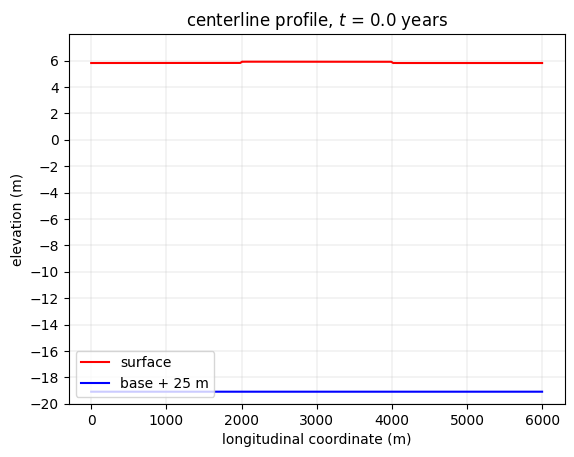

In [5]:
################################
################################
### parameters for iteration ###
################################
################################

Δt = 1/10 #length of timestep in years
num_timesteps = int(20/Δt) #spin up for 20 years

##################################
##################################
### parameters for flow solver ###
##################################
##################################

dirichlet_ids = [1] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
side_wall_ids = [3, 4]
ice_front_ids = [2]

ux_gl = 50 #upstream boundary boundary condition in meters per year
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity (u_x, u_y) for imposing Dirichlet BCs

flow_model = icepack.models.IceShelf(gravity = gravity2, terminus = terminus2, #model is icepack's SSA, but with our own physics
                                 side_friction = icepack.models.friction.side_friction)

flow_solver = icepack.solvers.FlowSolver(flow_model, dirichlet_ids = dirichlet_ids, 
                                    side_wall_ids = side_wall_ids, ice_front_ids = ice_front_ids)

#########################
#########################
### debris transport ####
#########################
#########################

debris_model = icepack.models.DamageTransport(damage_rate = 0.0, healing_rate = 0.0)
debris_solver = icepack.solvers.DamageSolver(debris_model)

r = 1000 #radius of the relict lake
px = Lx/2 #center coordinate of the lake
D = conditional(abs(x - px) < r, 0, 1) #D is 0 within 1000 meters of px, and 1 elsewhere
D = project(D, Q2)

a = -D #mass balance rate in meters per year
s0 = project(s0 + a*Δt, Q2) #update the initial surface elevation by adding one timestep's worth of ablation

#####################################
#####################################
### parameters for flexure solver ###
#####################################
#####################################

α = 1e10 #arbitrary large number for penalty method

η_transport_model = icepack.models.DamageTransport(damage_rate = 0.0, healing_rate = 0.0)
η_transport_solver = icepack.solvers.DamageSolver(η_transport_model)

#############################
#############################
### plot initial geometry ###
#############################
#############################

os.chdir('/home/sermilik/firedrake_stuff/figures/flow_flexure') #for saving figures
X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
s0_profile = s0.at(X, tolerance = 1e-10)
b0_profile = np.array(project(b0 + 25, Q2).at(X, tolerance = 1e-10)) #add 25 meters to the basal profile for a better plot window

plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.plot(s0_profile, color='red', label = 'surface')
plt.plot(b0_profile, color='blue', label = 'base + 25 m')
plt.legend(loc = 'lower left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.ylim(-20, 8)
plt.yticks(np.arange(-20, 8, 2))
plt.xticks(np.arange(0, Lx+1, 1000))
plt.grid(linewidth=0.2)
plt.savefig('iteration_0')

## Iteratively solve the flow-flexure problem

We'll also save plots of the surface and basal elevation profiles, along the centerline, at each timestep. The final iteration is shown below. 

100%|███████████████████████████████████████████████████████████████████████████████████| 21/21 [01:04<00:00,  3.08s/it]


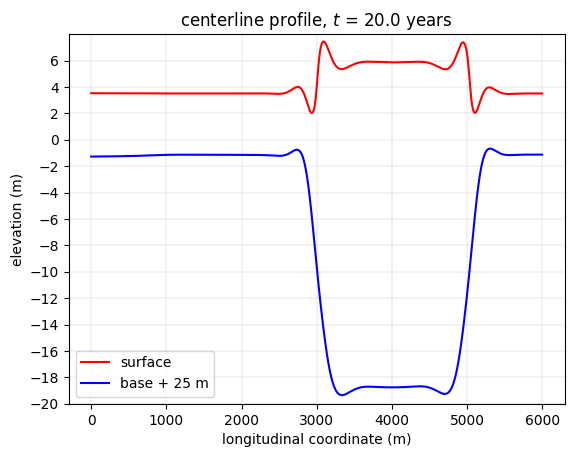

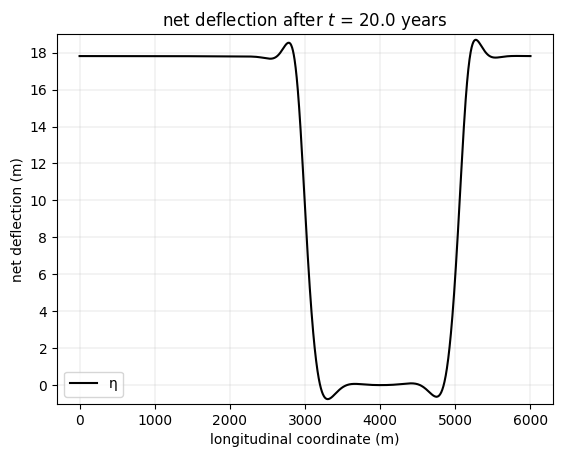

In [8]:
u, H, s, b = u0.copy(deepcopy=True), H0.copy(deepcopy=True), s0.copy(deepcopy=True), b0.copy(deepcopy=True) #initialize
Ση = Function(Q2).project(Constant(0)) #net deflection as the running sum of all individual deflections

for step in tqdm.trange(num_timesteps):
    
    #############################
    #############################
    ### get velocity solution ###
    #############################
    #############################
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), thickness = H, base = b, fluidity = A)
    
    ##################################
    ##################################
    ### dynamically thin the shelf ###
    ##################################
    ##################################
    
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u, #lower the surface 
                           thickness_inflow = Function(Q2).project(s), accumulation = Constant(0))
    
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u, #raise the base
                           thickness_inflow = Function(Q2).project(b), accumulation = Constant(0))


    s = project(s, Q1) #project surface elevation over Argyris elements
    b = project(b, Q1) #and basal elevation
    H = project(s - b, Q1) #and total thickness

    ########################################
    ########################################
    ### calculate some useful parameters ###
    ########################################
    ########################################

    ε, τ = Function(S), Function(S)
    ν = effective_viscosity(velocity = u)
    ε.project(sym(grad(u))) #strain rate tensor, /yr
    τ.project(2*ν*ε) #depth-averaged deviatoric stress tensor in Pascals
    p = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - p*Identity(2) #depth-averaged net stress 

    ##############################
    ##############################
    ### transport the sediment ###
    ##############################
    ##############################

    D = debris_solver.solve(Δt, damage = D, velocity = u, 
                            strain_rate = Function(S).project(Identity(2)), #these pamaters won't be used
                            membrane_stress = Function(S).project(Identity(2)), #...so just set them to the 2x2 Id matrix
                            damage_inflow = Constant(1.0)) #new debris should enter the upstream boundary
    a = -D #surface mass balance in meters per year

    ######################
    ######################
    ### flex the shelf ###
    ######################
    ######################

    h_ab = s + a*Δt + η - (1 - ϱ)*(H + a*Δt) #this will be the height above buoyancy once η is known

    #force flexure with surface mass balance (see Eq. 57a and 57c of MacAyeal et al. 2021)
    f = conditional(h_ab < 0, #if height above buoyancy is negative after flexing:
                    -ρ_w*g*h_ab, #f acts upward via buoyancy
                    -ρ_i*g*h_ab) #else: f acts downward via gravity
    
    #additionally force flexure with the velocity field, as in Eq. 57e 
    f += H*inner(σ, grad(grad(η + Ση))) #Eq. 57e

    L = (λ_1*(H**3)/12*inner(grad(grad(η + Ση)), ddw))*dx + λ_2*(H**3)/12*div(grad(η + Ση))*Δw*dx - f*w*dx #note the use of Ση + η
    L += 0.5*α**2*h_ab*w*ds(1) #constrain η so that h_ab is zero on the upstream boundary
    L += 0.5*α**2*h_ab*w*ds(2) #and the same at the downstream boundary

    solve(L == 0, η) #η is returned in meters per year
    Ση = project((Ση + η + 10)/100, Q2) #map onto values in [0, 1] for this to work with damage transport
    Ση = η_transport_solver.solve(Δt, damage = Ση, velocity = u, 
                                    strain_rate = Function(S).project(Identity(2)), 
                                    membrane_stress = Function(S).project(Identity(2)), 
                                    damage_inflow = Function(Q2).project(Ση))
    Ση = project(Ση*100 - 10, Q1) #and map back 

    #######################
    #######################
    ### adjust geometry ###
    #######################
    #######################
    
    b = project(b + η, Q2) #b is modified by the deflection
    s = project(s + a*Δt + η, Q2) #s is modified by deflection and surface mass balance 
    H = project(s - b, Q2) #new thickness
        
    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(project(b + 25, Q2).at(X, tolerance = 1e-10))
    η_profile = np.array(project(η, Q2).at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.plot(s_profile, color='red', label = 'surface')
    plt.plot(b_profile, color='blue', label = 'base + 25 m')
    plt.legend(loc = 'lower left')
    plt.ylim(-20, 8)
    plt.yticks(np.arange(-20, 8, 2))
    plt.xticks(np.arange(0, Lx+1, 1000))
    plt.grid(linewidth=0.2)
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

    η_profile = np.array(project(Ση, Q2).at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('net deflection after $t$ = {:.1f} years'.format(step*Δt + Δt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('net deflection (m)')
    plt.plot(η_profile, color='k', label = 'η')
    plt.legend(loc = 'lower left')
    plt.xticks(np.arange(0, Lx+1, 1000))
    plt.ylim(-1, 19)
    plt.yticks(np.arange(0, 19, 2))
    plt.grid(linewidth=0.2)
    plt.savefig('η_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration